In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import math
%matplotlib inline

In [2]:
def read_csv(file, idxname):
    data = pd.read_csv(file, delimiter="\t", header=None).reset_index().rename(columns = {0: "tokens", "index": idxname}).set_index("tokens")
    return data

def get_join_vocab(files, join="outer"):
    return pd.concat(files, axis=1, join="outer").reset_index()

def get_group(x, idx_col, group_size=300):
    x["group"] = np.floor(x[idx_col]/group_size)
    return x

## Loading Data

In [3]:
nfpa_en_vocab = read_csv("/home/ubuntu/cliang/train/pipeline_test_v2/preprocessed_data/NFPA_CS_Train_Vocab.en", "nfpa_idx")
euro_en_vocab = read_csv("/home/ubuntu/cliang/train/pipeline_test_v2/preprocessed_data/Europarl_Train_Vocab.en", "euro_idx")
merge_domain_vocab = read_csv("/home/ubuntu/cliang/train/pipeline_test_v2/domain_model/encoder-merge-NFPA_CS_Train_Vocab.en", "merge_idx")

## Mark the Tag of the Dataset

In [4]:
merged_vocab_data = get_join_vocab([nfpa_en_vocab, euro_en_vocab, merge_domain_vocab]).sort_values(by = "merge_idx")
merged_vocab_data[["in_nfpa", "in_euro"]] = merged_vocab_data[["nfpa_idx", "euro_idx"]].isnull().applymap(lambda x: not x)
merged_vocab_data["shared"] = merged_vocab_data.apply(lambda x: all([x["in_nfpa"],x["in_euro"]]), axis = 1)
merged_vocab_data["nfpa_only"] = merged_vocab_data.apply(lambda x: all([x["in_nfpa"],not x["shared"]]), axis = 1)
merged_vocab_data["euro_only"] = merged_vocab_data.apply(lambda x: all([x["in_euro"],not x["shared"]]), axis = 1)
merged_vocab_data["number_tokens"] = merged_vocab_data["index"].apply(lambda x: False if re.search('[a-zA-Z]', str(x)) else True)
merged_vocab_data["tag"] = merged_vocab_data.apply(lambda x: "".join([s for s in ["shared","nfpa_only","euro_only"] if x[s] == True]), axis = 1)

In [17]:
merged_vocab_data.sample(7)

,index,nfpa_idx,euro_idx,merge_idx,in_nfpa,in_euro,shared,nfpa_only,euro_only,number_tokens,tag
10912,▁adjudicating,17838.0,51315.0,51315.0,True,True,True,False,False,False,shared
78166,▁ramblings,NaN,69596.0,69596.0,False,True,False,False,True,False,euro_only
5433,leads,21446.0,68955.0,68955.0,True,True,True,False,False,False,shared
52376,▁chalki,NaN,46488.0,46488.0,False,True,False,False,True,False,euro_only
13645,▁blurs,NaN,28830.0,28830.0,False,True,False,False,True,False,euro_only
23814,▁hamas,NaN,3640.0,3640.0,False,True,False,False,True,False,euro_only
4929,im,18914.0,72008.0,72008.0,True,True,True,False,False,False,shared


## Merge Vocab Stats

In [19]:
temp = merged_vocab_data.agg({"shared":"sum","euro_only":"sum","nfpa_only":"sum"}).tolist()
pd.DataFrame(data = {"euro_only": temp[1], "shared": temp[0], "nfpa_only": temp[2]}, index=["count"])

,euro_only,nfpa_only,shared
count,63984,7921,16016


In [20]:
group_size = 1000
merge_vocab_stat_group = merged_vocab_data \
    .groupby(pd.cut(merged_vocab_data.merge_idx, np.arange(0, merged_vocab_data.merge_idx.max() + group_size, group_size))) \
    .agg({"shared":"sum","euro_only":"sum","nfpa_only":"sum"})

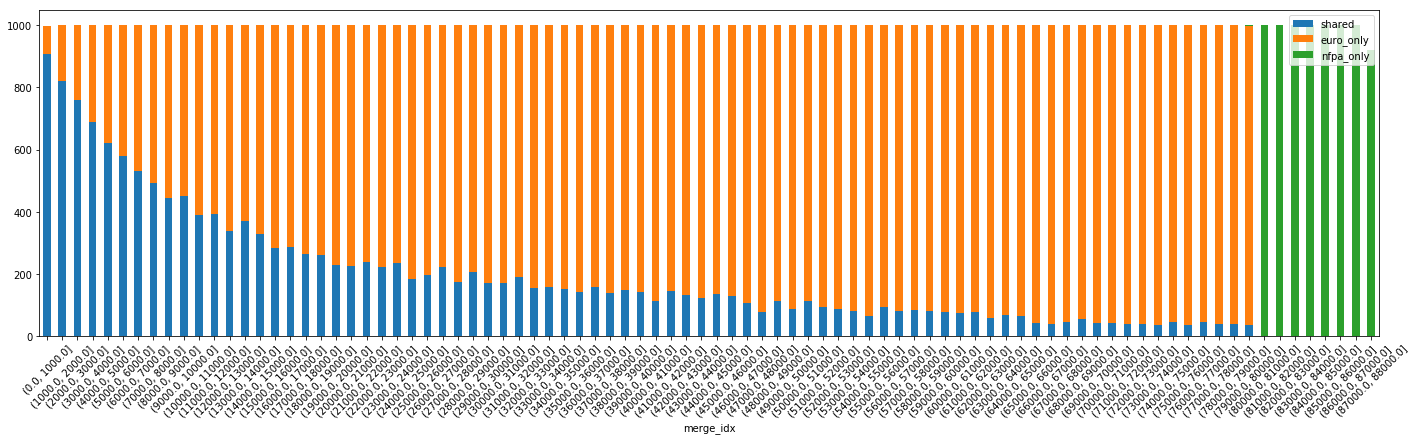

In [21]:
ax = merge_vocab_stat_group.plot.bar(figsize = (24,6), stacked = True)
ax.xaxis.set_tick_params(rotation=45)

## NFPA/Europarl Vocab Stats

In [22]:
group_size = 1000
nfpa_vocab_data = merged_vocab_data.loc[merged_vocab_data.in_nfpa == True]
nfpa_vocab_stat_group = nfpa_vocab_data.groupby(pd.cut(nfpa_vocab_data.nfpa_idx, np.arange(0, nfpa_vocab_data.nfpa_idx.max() + group_size, group_size))) \
    .agg({"shared":"sum","euro_only":"sum","nfpa_only":"sum"})

In [23]:
group_size = 3000
euro_vocab_data = merged_vocab_data.loc[merged_vocab_data.in_euro == True]
euro_vocab_stat_group = euro_vocab_data.groupby(pd.cut(euro_vocab_data.euro_idx, np.arange(0, euro_vocab_data.euro_idx.max() + group_size, group_size))) \
    .agg({"shared":"sum","euro_only":"sum","nfpa_only":"sum"})

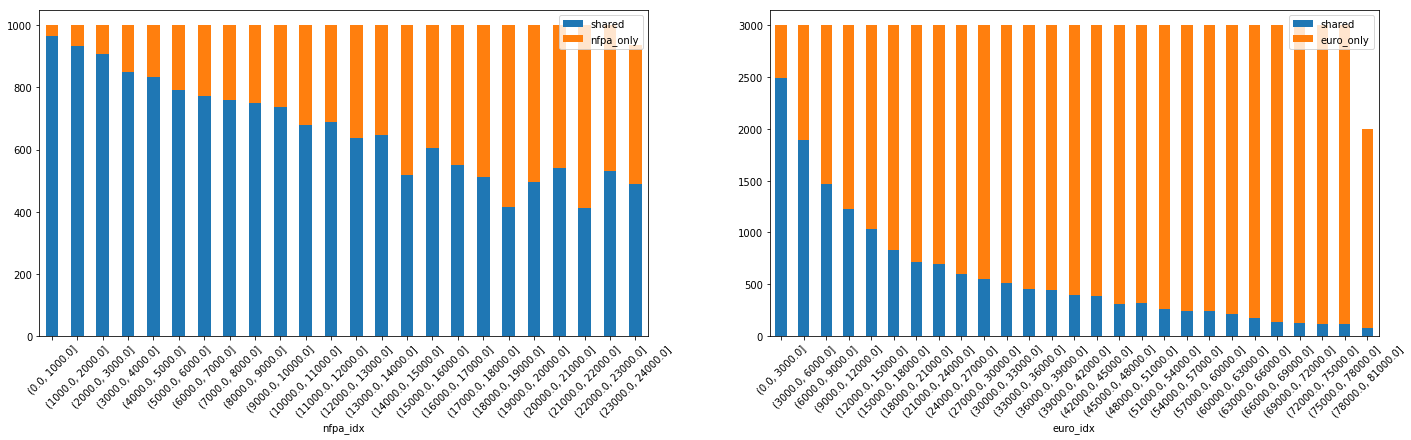

In [24]:
fig, axes = plt.subplots(ncols=2)
ax1 = nfpa_vocab_stat_group.plot.bar(figsize = (24,6), stacked = True, ax = axes[0])
ax1.xaxis.set_tick_params(rotation=45)
ax2 = euro_vocab_stat_group.plot.bar(figsize = (24,6), stacked = True, ax = axes[1])
ax2.xaxis.set_tick_params(rotation=45)

## Token Character Length Analysis

In [25]:
share_vocab_data = merged_vocab_data.loc[merged_vocab_data.shared == True]

#### Token character length in different vocab file
- different vocab file, their token are following similar distribution
- shared tokens are more concentrated on 5-10 chars, while europarl and nfpa only tokens owns a small tail on the right

In [35]:
merged_vocab_data["char_length"] = merged_vocab_data["index"].map(lambda x: len(list(str(x))))
nfpa_vocab_data["char_length"] = nfpa_vocab_data["index"].map(lambda x: len(list(str(x))))
share_vocab_data["char_length"] = share_vocab_data["index"].apply(lambda x: len(list(str(x))))
euro_vocab_data["char_length"] = euro_vocab_data["index"].apply(lambda x: len(list(str(x))))
merged_vocab_data.sample(5)

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using

,index,nfpa_idx,euro_idx,merge_idx,in_nfpa,in_euro,shared,nfpa_only,euro_only,number_tokens,tag,char_length
56397,▁haute,NaN,43957.0,43957.0,False,True,False,False,True,False,euro_only,6
54746,▁ermacora,NaN,56831.0,56831.0,False,True,False,False,True,False,euro_only,9
69846,▁berkeley,NaN,56987.0,56987.0,False,True,False,False,True,False,euro_only,9
27369,▁lawnmowers,NaN,28950.0,28950.0,False,True,False,False,True,False,euro_only,11
55664,▁gach,NaN,53601.0,53601.0,False,True,False,False,True,False,euro_only,5


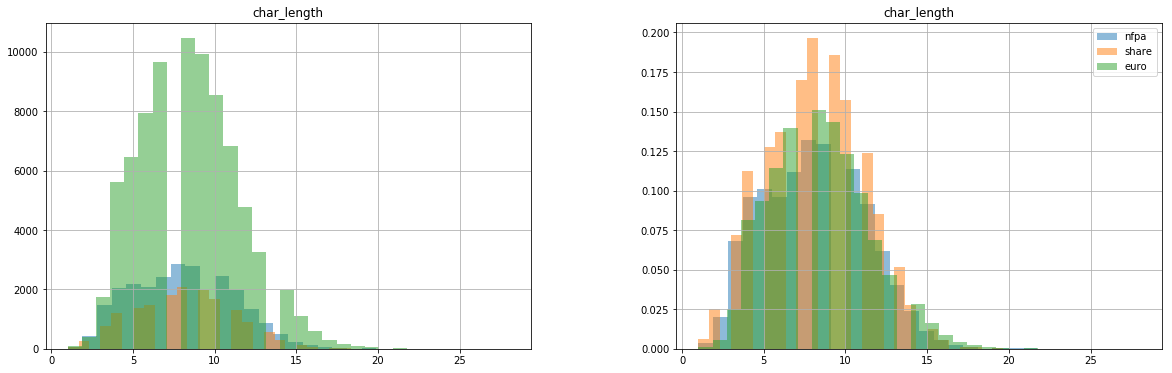

In [27]:
fig, axes = plt.subplots(ncols = 2, figsize = (20,6))
nfpa_vocab_data.hist("char_length", bins = 30, ax = axes[0], label = "nfpa", alpha = .5)
share_vocab_data.hist("char_length", bins = 30, ax = axes[0], label = "share", alpha = .5)
euro_vocab_data.hist("char_length", bins = 30, ax = axes[0], label = "euro", alpha = .5)
nfpa_vocab_data.hist("char_length", bins = 30, ax = axes[1], label = "nfpa", alpha = .5, density = True)
share_vocab_data.hist("char_length", bins = 30, ax = axes[1], label = "share", alpha = .5, density = True)
euro_vocab_data.hist("char_length", bins = 30, ax = axes[1], label = "euro", alpha = .5, density = True)
plt.legend()

#### Token character length in different index 
- index increase indicate **higher freq -> lower freq**

In [66]:
group_size = 10000
merge_vocab_stat_group_cl = merged_vocab_data.groupby([pd.cut(merged_vocab_data.merge_idx, np.arange(0, merged_vocab_data.merge_idx.max() + group_size, group_size)), "tag"]) \
    .agg({"char_length": ["mean", "median", "min", "max"]})

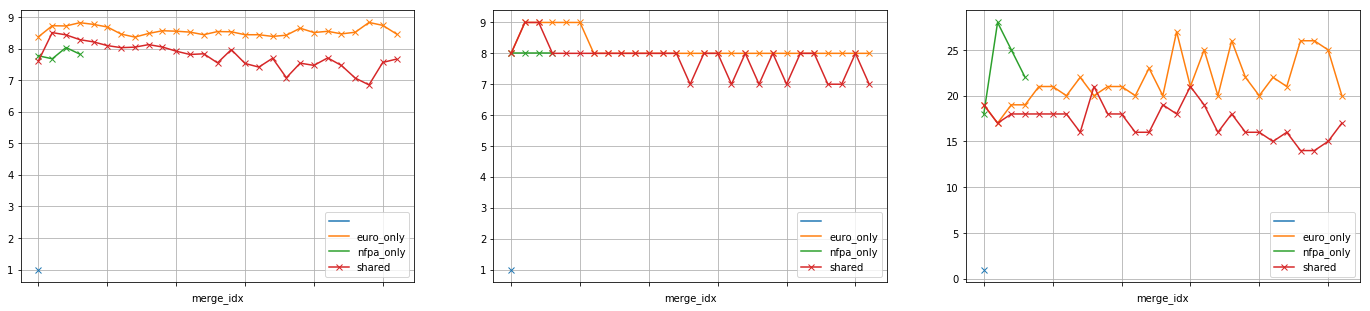

In [54]:
fig, axes = plt.subplots(ncols = 3, figsize = (24,5), sharex=True)
for label, df in merge_vocab_stat_group_cl.reset_index().groupby("tag"):
#     print(label, df.head())
    ax0 = df.plot.line("merge_idx", ("char_length","mean"), label=label, ax=axes[0], marker = "x")
    ax0.grid()
    ax1 = df.plot.line("merge_idx", ("char_length","median"), label=label, ax=axes[1], marker = "x")
    ax1.grid()
    ax2 = df.plot.line("merge_idx", ("char_length","max"), label=label, ax=axes[2], marker = "x")
    ax2.grid()

## Number Tokens Analysis

In [116]:
group_size = 3000
merge_vocab_stat_group_nb = merged_vocab_data.copy()
merge_vocab_stat_group_nb = merge_vocab_stat_group_nb.groupby([pd.cut(merge_vocab_stat_group_nb.merge_idx, np.arange(0, merge_vocab_stat_group_nb.merge_idx.max() + group_size, group_size)), "tag", "number_tokens"]) \
    .agg({"index": "count"}).rename(columns = {"index": "token_cnt"}).reset_index(["tag"])

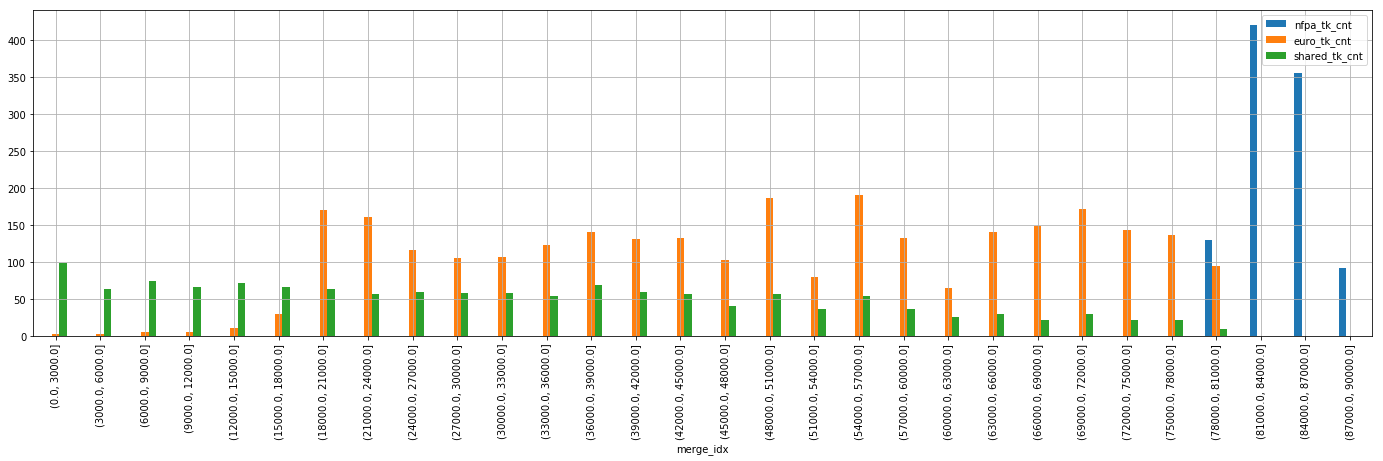

In [133]:
nfpa_tk_df = merge_vocab_stat_group_nb.loc[merge_vocab_stat_group_nb.tag == "nfpa_only"].rename(columns = {"token_cnt":"nfpa_tk_cnt"}).drop("tag", axis = 1)
euro_tk_df = merge_vocab_stat_group_nb.loc[merge_vocab_stat_group_nb.tag == "euro_only"].rename(columns = {"token_cnt":"euro_tk_cnt"}).drop("tag", axis = 1)
shared_tk_df = merge_vocab_stat_group_nb.loc[merge_vocab_stat_group_nb.tag == "shared"].rename(columns = {"token_cnt":"shared_tk_cnt"}).drop("tag", axis = 1)
concat_tk_df = pd.concat([nfpa_tk_df, euro_tk_df, shared_tk_df], axis = 1)
ax = concat_tk_df.reset_index().loc[concat_tk_df.reset_index().number_tokens == True].plot(x = "merge_idx", kind = "bar", figsize = (24,6))
ax.grid()